# SDCND Behavioural Cloning

In [1]:
# Imports
import os
import csv
import math
import random

import cv2
import pickle
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, MaxPooling2D
from keras.regularizers import l2, activity_l2
from keras.optimizers import Adam
from keras.layers.convolutional import Convolution2D

import matplotlib.pyplot as plt
%matplotlib inline

random.seed(137)
np.random.seed(137)

Using TensorFlow backend.


In [2]:
# Load Data
TRAINING_DIR = "/Users/Mango/Documents/Development/Learning Plus Challenges/SDC/Term 1/CarND-Behavioral-Cloning-P3/Training Data/"

def load_data(file_path):
    X_data = []
    y_data = []
    with open(TRAINING_DIR + file_path) as logs:
        img_col, steering_col, speed_col = 0, 3, 6
        for log in csv.reader(logs):
            try:
                if not os.path.isfile(log[img_col]):
                    continue
                if float(log[speed_col]) < 0.001:
                    continue
                if float(float(log[steering_col])) == 0 and random.randint(0,5) < 5:
                    continue
                X_data.append(log[img_col])
                y_data.append(float(log[steering_col]))
            except ValueError:
                pass
    return np.array(X_data), np.array(y_data)

X_data, y_data = load_data('driving_log.csv')
X_recover, y_recover = load_data('recovery/driving_log.csv')

print(len(np.append(y_data, y_recover)), "logs found")

11404 logs found


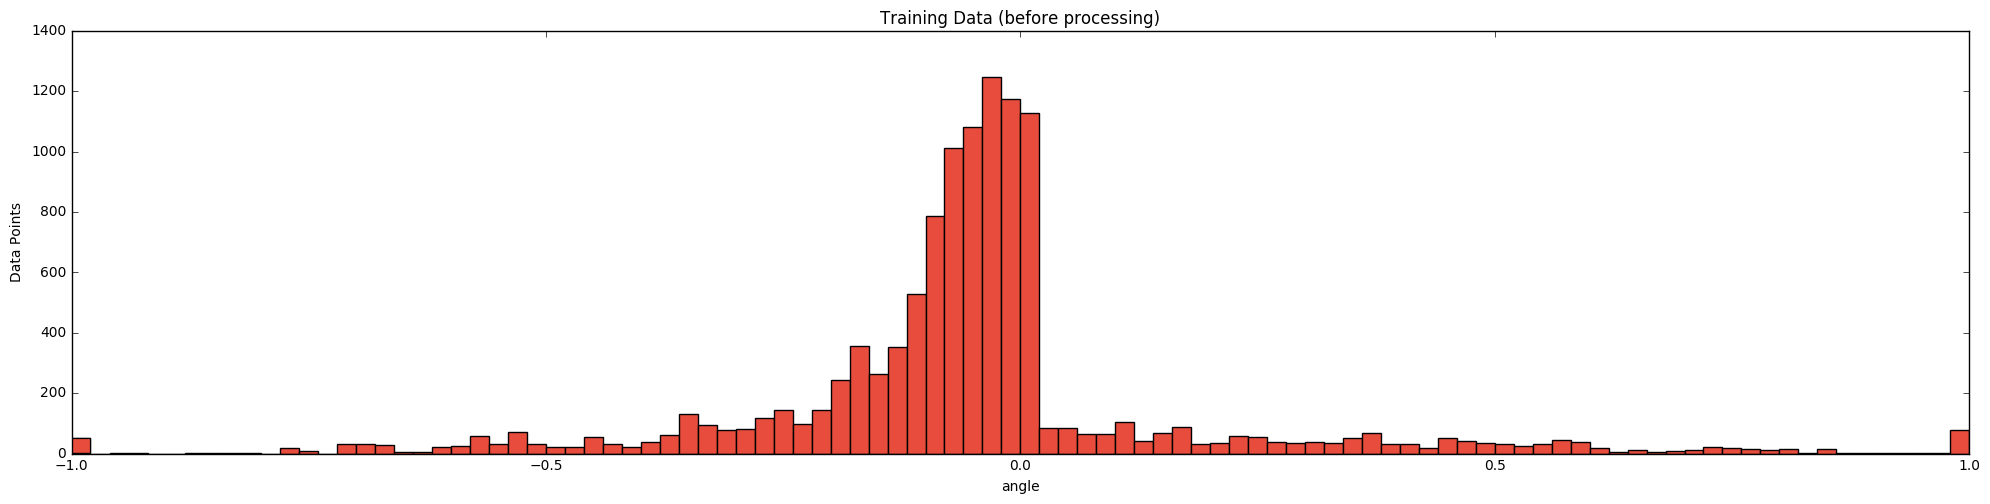

In [3]:
# Visualize Data
def generate_graph(y_data, x_label='angle', y_label='Data Points', title='', bins=100):
    fig, ax = plt.subplots(figsize=(20, 5))
    n, bins, patches = ax.hist(y_data, bins=bins, range=(-1,1), color="#E74C3C", alpha=1.0)
#     n, bins, patches = ax.hist(moving_average(y_data), bins=100, range=(-1.0,1.0), color="#2C3E50", alpha=0.75)
    ax.set_xlabel('Angle')
    ax.set_ylabel('Data Points')
    fig.tight_layout()
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    
generate_graph(np.append(y_data, y_recover), title='Training Data (before processing)')

In [4]:
# Preprocess Data

TRANS_RANGE = 100

def read_img(img_path, augmented=False):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    if augmented:
        return img
    return img[55:140]

def write_img(img, img_path):
    img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
    return cv2.imwrite(img_path, img)

def augment_flip(img, steering_angle, force=False):
    if random.getrandbits(1) or force:
        img = cv2.flip(img,1)
        steering_angle *= -1
    return img, steering_angle

def augment_translation(img, steering):
    rows, cols, _ = img.shape
    t_x = TRANS_RANGE*np.random.uniform()-TRANS_RANGE/2
    
    steering = steering + t_x/TRANS_RANGE*2*.2
    
    Trans_M = np.float32([[1,0,t_x],[0,1,0]])
    image_tr = cv2.warpAffine(img,Trans_M,(cols,rows))
    
    return image_tr, steering, t_x

def augment_brightness_and_shadow(img):
    img, bright = augment_brightness(img)
    min_shade = .5
    # shadow part is never less than min_shade of total, max is always 100%
    random_bright = min_shade/bright + np.random.uniform()*(1-min_shade/bright)
    
    return augment_shadow(img, random_bright)

def augment_brightness(img):
    random_bright = .5+np.random.uniform()*0.5 # between 50% and 100%
    
    # Works better in HSV colorspace
    img_hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    img_hsv[:,:,2] = img_hsv[:,:,2]*random_bright
    
    return cv2.cvtColor(img_hsv,cv2.COLOR_HSV2RGB), random_bright

def augment_shadow(img, brightness):
    rows, cols, _ = img.shape
    top_y = cols*np.random.uniform()
    top_x = 0
    bot_x = rows
    bot_y = cols*np.random.uniform()
    image_hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    shadow_mask = 0*image_hsv[:,:,2]
    X_m = np.mgrid[0:rows, 0:cols][0]
    Y_m = np.mgrid[0:rows, 0:cols][1]
    shadow_mask[((X_m-top_x)*(bot_y-top_y) -(bot_x - top_x)*(Y_m-top_y) >=0)]=1
    
    cond = shadow_mask == random.getrandbits(1)
    image_hsv[:,:,2][cond] = image_hsv[:,:,2][cond]*brightness  
    
    return cv2.cvtColor(image_hsv,cv2.COLOR_HSV2RGB)

def moving_average(data, n=3):
    """
    Calculate moving average
    http://stackoverflow.com/a/14314054
    """
    if n==1 or len(data) < n:
        return data
    
    ma = np.cumsum(data, dtype=float)
    ma[n:] = ma[n:] - ma[:-n]
    return np.append(ma[:n - 1], ma[n - 1:] / n)

def augment_image(img, steering):
    img, steering = augment_flip(img, steering)
    img, steering, t_x = augment_translation(img, steering)
    
    img = augment_brightness_and_shadow(img)
    return img, steering, t_x
    

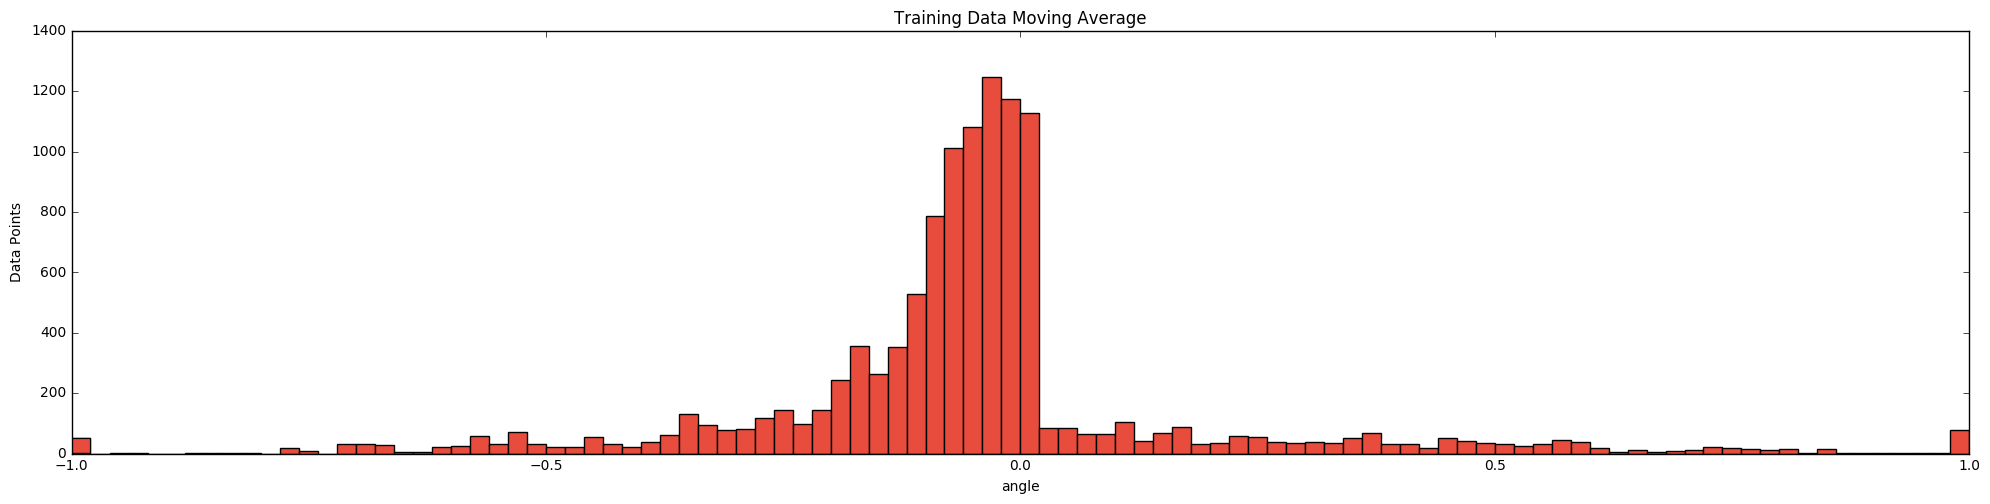

In [5]:
# Test Preprocessing Part 1

y_data_ma = moving_average(y_data)
y_recover_ma = moving_average(y_recover)
generate_graph(np.append(y_data, y_recover), title='Training Data Moving Average')

8018


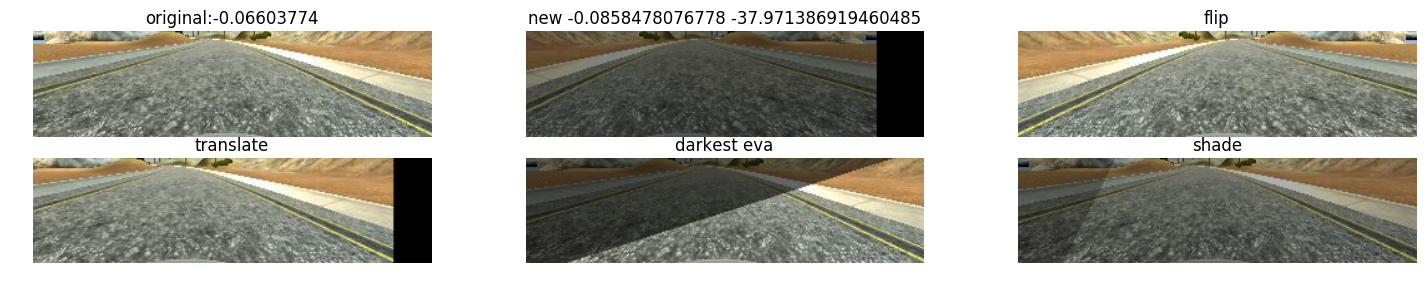

In [42]:
# Test Preprocessing Part 2
def compare_images(images, rows=2, cols=None, figsize=None:
    img_count = len(images)
    if cols is None:
        cols = img_count
    if figsize is None:
                   
    fig, axs = plt.subplots(rows, cols, figsize=figsize)
    for row in range(len(axs)):
        colsize = len(axs[row])
        for col in range(colsize):
            index = colsize*row + col
            axs[row][col].axis('off')
            axs[row][col].set_title(images[index][0])
            axs[row][col].imshow(images[index][1].squeeze())


            
index = 8018 # random.randint(0, len(X_data)-1) # 28th
print(index)
o_img, o_lbl = read_img(X_data[index]), y_data_ma[index]

aug_img, steer, t_x = augment_image(o_img, o_lbl)

images = [
    ('original:' + str(o_lbl), o_img),
    ('new ' + str(steer) + ' ' + str(t_x),      aug_img),
    ('flip',                   augment_flip(o_img, o_lbl)[0]),
    ('translate',              augment_translation(o_img, o_lbl)[0]),
    ('darkest eva',             augment_shadow(o_img, .4)),
    ('shade',                  augment_brightness_and_shadow(o_img)),
]

compare_images(images, 2, 3)

In [7]:
# Augment Data
X_data_aug = []
y_data_aug = []

MIN_SAMPLES = 2000

if not os.path.exists(TRAINING_DIR + 'augmented_log.csv'):
    print("Files not found, generating images...", flush=True)
    created = 0
    for i in range(len(X_data)):
        x, y = read_img(X_data[i]), y_data_ma[i]
        x2, y2 = augment_flip(x,y,True)
        X_data_aug.append(x)
        y_data_aug.append(y)
        X_data_aug.append(x2)
        y_data_aug.append(y2)

        if created % 1000 == 0:
            print(created, end='', flush=True)
        elif created % 100 == 0:
            print('|', end='', flush=True)
        created += 1
    created = 0
        
    for i in range(len(X_recover)):
        x, y = read_img(X_recover[i]), y_recover_ma[i]
        x2, y2 = augment_flip(x,y,True)
        X_data_aug.append(x)
        y_data_aug.append(y)
        X_data_aug.append(x2)
        y_data_aug.append(y2)

        if created % 1000 == 0:
            print(created, end='', flush=True)
        elif created % 100 == 0:
            print('|', end='', flush=True)
        created += 1
    created = 0

    for i in np.arange(-1,1,0.1):
        indexes = np.where((i < y_data_ma) & (y_data_ma < i + 0.1))[0]
        count = len(indexes)
        if count == 0:
            continue
        if count < MIN_SAMPLES:
            print("Generating data for section", i, "-", i + 0.1, flush=True)
            for c in range(MIN_SAMPLES - count):
                index = random.choice(indexes)
                x, y = read_img(X_data[index]), y_data_ma[index]
                x, y, _ = augment_image(x, y)
                X_data_aug.append(x)
                y_data_aug.append(y)

            if created % 1000 == 0:
                print(created, end='', flush=True)
            elif created % 100 == 0:
                print('|', end='', flush=True)
            created += 1
    created = 0

    for i in np.arange(-1,1,0.1):
        indexes = np.where((i < y_data_ma) & (y_data_ma < i + 0.1))[0]
        count = len(indexes)
        if count == 0:
            continue
        if count < MIN_SAMPLES:
            print("Generating data for section", i, "-", i + 0.1, flush=True)
            for c in range(MIN_SAMPLES - count):
                index = random.choice(indexes)
                x, y = read_img(X_data[index]), y_data_ma[index]
                x, y, _ = augment_image(x, y)
                X_data_aug.append(x)
                y_data_aug.append(y)

            if created % 1000 == 0:
                print(created, end='', flush=True)
            elif created % 100 == 0:
                print('|', end='', flush=True)
            created += 1
    created = 0

    for i in np.arange(-1,1,0.1):
        indexes = np.where((i < y_recover_ma) & (y_recover_ma < i + 0.1))[0]
        count = len(indexes)
        if count == 0:
            continue
        if count >= MIN_SAMPLES:
            count = MIN_SAMPLES - 200
        if count < MIN_SAMPLES:
            print("Generating data for section", i, "-", i + 0.1, flush=True)
            print("starting with", count)
            for c in range(MIN_SAMPLES - count):
                index = random.choice(indexes)
                x, y = read_img(X_recover[index]), y_recover_ma[index]
                x, y, _ = augment_image(x, y)
                X_data_aug.append(x)
                y_data_aug.append(y)

            if created % 1000 == 0:
                print(created, end='', flush=True)
            elif created % 100 == 0:
                print('|', end='', flush=True)
            created += 1
    created = 0
            
    print('', flush=True)
    print("Saving Random Order...", len(X_data_aug), flush=True)
    csv_data = []
    X_data_aug, y_data_aug = shuffle(X_data_aug, y_data_aug)
    os.makedirs(TRAINING_DIR + 'IMG_augmented/')
    for i in range(len(X_data_aug)):
        path = TRAINING_DIR + 'IMG_augmented/{0:05d}'.format(i)+'.jpg'
        write_img(X_data_aug[i], path)
        csv_data.append([path, y_data_aug[i]])
        
    print("Saved images", flush=True)
    with open(TRAINING_DIR + 'augmented_log.csv', 'w') as f:
        csv_writer = csv.writer(f)
        csv_writer.writerows(csv_data)
    print("Done Saving!", flush=True)

In [8]:
# # Augment Data
# X_data_aug = []
# y_data_aug = []

# X_file = 'X_train_augmented.p'
# y_file = 'y_train_augmented.p'

# if not os.path.exists(TRAINING_DIR + 'augmented_log.csv'):
#     print("Files not found, generating images...", flush=True)
#     for i in range(len(X_data)):
#         x, y = read_img(X_data[i]), y_data_ma[i]
#         if random.getrandbits(1):
#             x, y = augment_flip(x,y,True)
#         X_data_aug.append(x)
#         y_data_aug.append(y)
#         for _ in range(2):
#             x_aug, y_aug, _ = augment_image(x, y)
#             X_data_aug.append(x_aug)
#             y_data_aug.append(y_aug)
            
#         left = len(X_data)-i
#         if left % 1000 == 0:
#             print(left, end='', flush=True)
#         elif left % 100 == 0:
#             print('|',end='', flush=True)
            
#     print('', flush=True)
#     print("Generating recovery...", flush=True)
#     for i in range(len(X_recover)):
#         x, y = read_img(X_recover[i]), y_recover_ma[i]
#         if random.getrandbits(1):
#             x, y = augment_flip(x,y,True)
#         X_data_aug.append(x)
#         y_data_aug.append(y)
#         for _ in range(4):
#             x_aug, y_aug, _ = augment_image(x, y)
#             X_data_aug.append(x_aug)
#             y_data_aug.append(y_aug)
        
#         left = len(X_data)-i
#         if left % 1000 == 0:
#             print(left, end='', flush=True)
#         elif left % 100 == 0:
#             print('|',end='', flush=True)
            
#     print('', flush=True)
#     print("Saving Random Order...", len(X_data_aug), flush=True)
#     csv_data = []
#     X_data_aug, y_data_aug = shuffle(X_data_aug, y_data_aug)
#     os.makedirs(TRAINING_DIR + 'IMG_augmented/')
#     for i in range(len(X_data_aug)):
#         path = TRAINING_DIR + 'IMG_augmented/{0:05d}'.format(i)+'.jpg'
#         write_img(X_data_aug[i], path)
#         csv_data.append([path, y_data_aug[i]])
        
#     print("Saved images", flush=True)
#     with open(TRAINING_DIR + 'augmented_log.csv', 'w') as f:
#         csv_writer = csv.writer(f)
#         csv_writer.writerows(csv_data)
#     print("Done Saving!", flush=True)

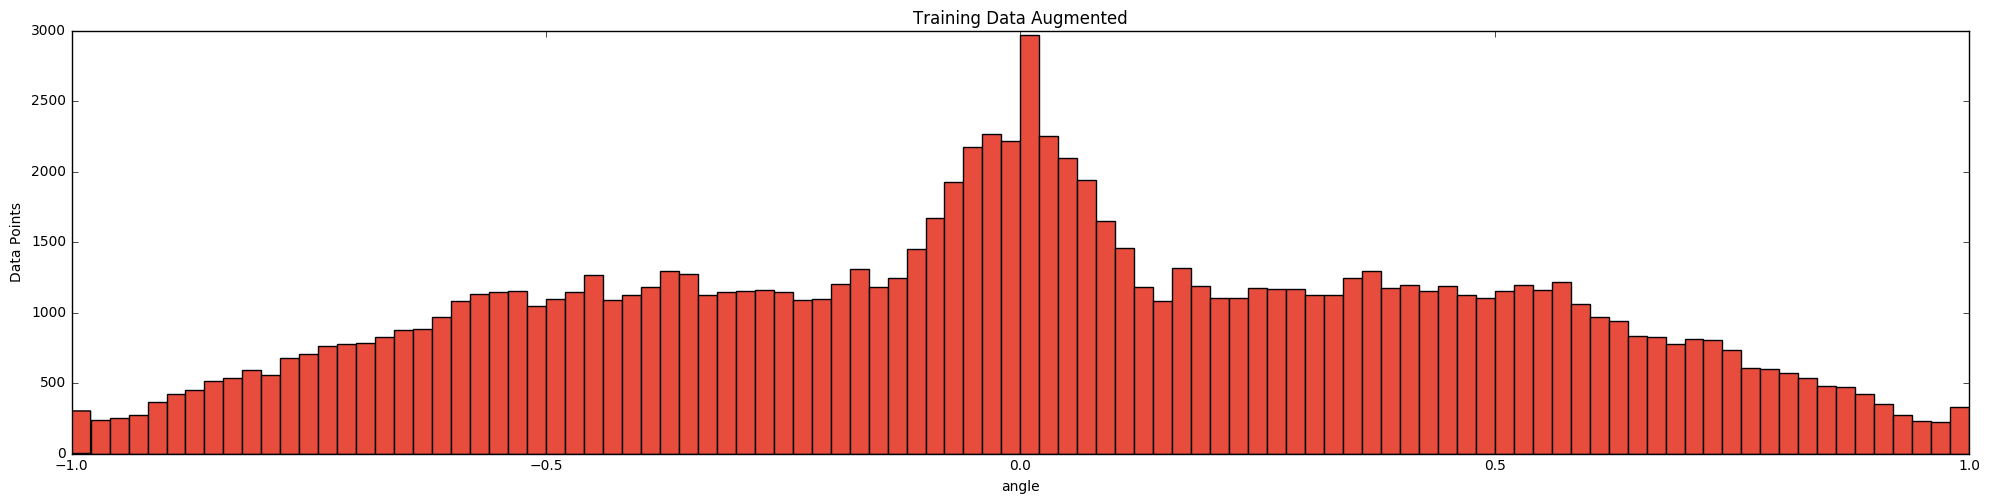

In [9]:
# Load and Visualize Augmented Data
X_data_aug = []
y_data_aug = []

with open(TRAINING_DIR + 'augmented_log.csv', 'r') as logs:
    for log in csv.reader(logs):
        X_data_aug.append(log[0])
        y_data_aug.append(float(log[1]))
        
generate_graph(y_data_aug, title='Training Data Augmented')

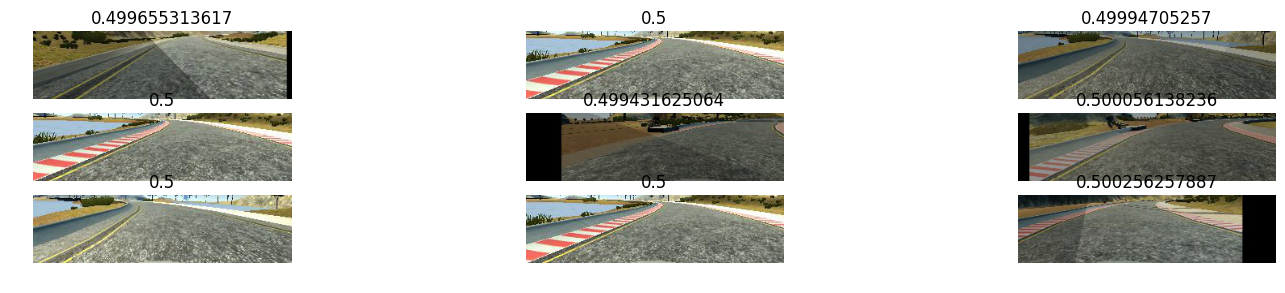

In [43]:
indexes = np.where((0.499 < np.asarray(y_data_aug)) & (np.asarray(y_data_aug) < 0.501))[0]
pics = []
for _ in range(9):
    i = random.choice(indexes)
    pics.append((str(y_data_aug[i]), read_img(X_data_aug[i], True)))
compare_images(pics, 3, 3)

In [ ]:
# Split Data
X_train, X_valid, y_train, y_valid = train_test_split(X_data_aug, y_data_aug, train_size=0.75)

In [ ]:
# Hyperparameters

BATCH_SIZE = 64
IMG_HEIGHT = 64
IMG_WIDTH  = 64
EPOCHS = 10


In [ ]:
# Generator
def resize(img):
    return cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT), interpolation=cv2.INTER_AREA)

In [ ]:
# Model

def commaai_model(time_len=1):
    ch, row, col = 3, 66, 200  # camera format

    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,
            input_shape=(row, col, ch),
            output_shape=(row, col, ch)))
    model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(Flatten())
    model.add(Dropout(.2))
    model.add(ELU())
    model.add(Dense(512))
    model.add(Dropout(.2))
    model.add(ELU())
    model.add(Dense(1))

    model.compile(optimizer="adam", loss="mse")

    return model

def nvidia_model():
    model = Sequential()

    model.add(Lambda(lambda x: x/127.5 - 1.0, input_shape=(64,64,3)))

    model.add(Convolution2D(24,5,5, border_mode='valid', W_regularizer=l2(0.01), activation='elu', subsample=(2,2)))
    model.add(Convolution2D(36,5,5, border_mode='valid', activation='elu', subsample=(2,2)))
    model.add(Convolution2D(48,5,5, border_mode='valid', activation='elu', subsample=(2,2)))
    model.add(Convolution2D(64,3,3, border_mode='valid', activation='elu', subsample=(1,1)))
    model.add(Convolution2D(64,3,3, border_mode='valid', activation='elu', subsample=(1,1)))
    model.add(Flatten())
    model.add(Dense(1164, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='tanh'))

    model.compile(optimizer=Adam(lr=1e-4), loss='mean_squared_error')

    return model

In [ ]:
# Train

def generate_data(images, angles):
    while True:
        for i in range(0, len(images), BATCH_SIZE):
            end = min(i+BATCH_SIZE, len(images))

            batch_image = np.zeros((end-i, IMG_HEIGHT, IMG_WIDTH, 3))
            batch_label = np.zeros(end-i)
            for j in range(i, end):
                img, steering = images[j], angles[j]
                img = resize(read_img(img, True))
                batch_image[j-i] = img
                batch_label[j-i] = steering

            yield(batch_image, batch_label)

In [ ]:
def train():
    checkpoint = ModelCheckpoint("weights.{epoch:02d}-{val_loss:.2f}.hdf5", monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
    model = commaai_model()
    history = model.fit_generator(
        generate_data(X_train, y_train),
        samples_per_epoch=len(X_train),
        validation_data=generate_data(X_valid, y_valid),
        nb_val_samples=len(X_valid),
        nb_epoch=EPOCHS,
        callbacks=[checkpoint],
        verbose=1
        )
    return model

train()

In [ ]:
# Visualize